# Homework 1. Likelihood-based models

- Task 1 (5 points): Warmup
- Task 2 (10 points): PixelCNN
- Task 3 (10 points): Conditional PixelCNN
- **Task 4 (10 points): RealNVP**
- \* Bonus (10+++ points)

# Task 4. 2D Continuous Data. RealNVP flow model

In this part we will build flow model, transforming given 2D continuous distribution to uniform 2D distribution. Our distribution will be represented as a set of samples. We will use RealNVP model, which we discussed on lecture.

First of all, we define function for data sampling, use it and perform train/val/test split as usual. This time all elements also have labels, associated with them. We wil use them for visualization purposes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torch.distributions.uniform import Uniform
import math
from sklearn.model_selection import train_test_split
import random

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def sample_data():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]

    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

In [3]:
X, Y = sample_data()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2)

Let's take a look on a 2D histogram of our train set distribution.

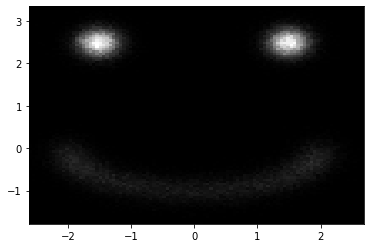

In [4]:
plt.hist2d(X_train.T[0], X_train.T[1], bins=100, cmap='gray')
plt.show()

Let's also visualize distribution in point form with different colors, associated with labels.

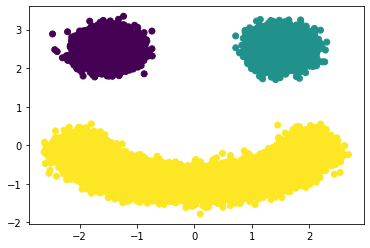

In [5]:
plt.scatter(X_train.T[0], X_train.T[1], c = Y_train)
plt.show()

We will build RealNVP flow model using affine coupling layer as main building block. In two-coordinates case it takes the following form:

$$ (x_1, x_2) \rightarrow (z_1, z_2) $$
$$ z_1 = x_1 $$
$$ z_2 = x_2 \cdot \sigma(s(x_1)) + t(x_1) $$

Where vector from $s, t$ values is calculated as neural network with $x_1$ on input and $\sigma$ is sigmoid function. Cool thing about RealNVP is that this network can be arbitrary complex and doesn't need to be invertible itself to have invertible flow for affine coupling layer!

Flows support composition and we will use it. In general, we will compose our total flow in the following way:

$$ (z_1, z_2) = (\sigma \circ f_{\theta, 1} \circ \dots \circ f_{\theta, n})(x_1, x_2) $$

Where $f_{\theta, i}$ is affine coupling layers described above. And $\sigma$ is elementwise sigmoid function

Important thing in flows training is loss function. In case of flows composition, log-likelihood objective takes the following form:

$$ \log p_\theta(x) = \log p_\theta(z) + \sum_i \log | \det \frac{\partial f_i}{\partial f_{i-1}}| $$

Here $\det \frac{\partial f_i}{\partial f_{i-1}}$ is Jacobian matrix determinant for each flow operation. And $\log p_\theta(z)$ is log likelihood of latent space we are mapping to (in our case $U(0, 1)^2$)

Answer the following questions (you will need the answers to complete your RealNVP model code):

1. What is $\log | \det \frac{\partial f_i}{\partial f_{i-1}} |$ for affine coupling operation?
2. What is $\log | \det \frac{\partial f_i}{\partial f_{i-1}} |$ for elementwise sigmoid operation?
3. What are the inverse operations for both sigmoid and affine coupling?
4. How $\log p_\theta(z)$ in case of $U(0, 1)^2$ can be calculated?

We will start implementation of RealNVP from affine coupling layer. You will need to implement inverse operation calculations as well as objective update for each layer ($\log | \det \frac{\partial f_i}{\partial f_{i-1}} |$).

In [6]:
class AffineCoupling(nn.Module):
    def __init__(self, num_features=2):
        super(AffineCoupling, self).__init__()
        # Store your NN model for s and t values calculation
        # Your network should take num_features // 2 elements on input (1 in our case)
        # And return num_features elements on output (1 in our case)
        self.NN = nn.Sequential(
            nn.Linear(num_features // 2, 32), 
            nn.ReLU(), 
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_features),
        )
    
    # Forward pass is implemented for you. Implement your objective update
    def forward(self, x, objective):
        z1, z2 = torch.chunk(x, 2, dim=1)
        h = self.NN(z1)
        shift = h[:, 0::2]
        scale = torch.sigmoid(h[:, 1::2])

        z2 = z2 + shift
        z2 = z2 * scale
        objective += torch.sum(torch.log(scale + 1e-8), dim=1)
        
        return torch.cat([z1, z2], dim=1), objective
    
    # Implement reverse value calculation
    def reverse(self, x):
        z1, z2 = torch.chunk(x, 2, dim=1)
        h = self.NN(z1)
        shift = h[:, 0::2]
        scale = torch.sigmoid(h[:, 1::2])

        z2 = z2 - shift
        z2 = z2 / scale

        return torch.cat([z1, z2], dim=1)

Now do the same for elementwise sigmoid function.

In [7]:
# Elementwise sigmoid flow from R^n to (0; 1)^n
class ElementwiseSigmoid(nn.Module):
    def __init__(self):
        super(ElementwiseSigmoid, self).__init__()
    
    def forward(self, x, objective):
        x = torch.sigmoid(x)
        objective += torch.sum(torch.log(x * (1. - x) + 1e-8), dim=1)
        return x, objective
    
    def reverse(self, x):
        x = torch.log(x) - torch.log(1 - x)
        return x

We will also need to swap dimensions from time to time for affine couling layer, so it leaves different parts of input the same on different iterations. Answer the following questions:
1. Is this operation legal? Is it a flow? What is the reverse operation?
2. That is $\log | \det \frac{\partial f_i}{\partial f_{i-1}} |$ for this operation?

In [8]:
def dimensions_swap(x):
    x1, x2 = torch.chunk(x, 2, dim=1)
    return torch.cat([x2, x1], dim=1)

Finally, we build RealNVP model from defined operations. Feel free to change number of affine coupling layers inside the model.

In [9]:
class RealNVP(nn.Module):
    def __init__(self, n_transforms=5):
        super(RealNVP, self).__init__()
        
        self.affines = nn.ModuleList([AffineCoupling() for _ in range(n_transforms)])
        self.sigmoid = ElementwiseSigmoid()
        
    def forward(self, x):
        objective = 0
        for layer in self.affines:
            x, objective = layer(x, objective)
            x = dimensions_swap(x)

        x, objective = self.sigmoid(x, objective)
        
        return x, objective
    
    def reverse(self, x):
        x = self.sigmoid.reverse(x)
        for layer in reversed(self.affines):
            x = dimensions_swap(x)
            x = layer.reverse(x)
            
        return x

At last, we define training procedure. Here we have calculated our total objective from flows log-det-s, however, we still need to define our loss, which we need to minimize. We also want to accumulate training loss values in bits. Fill this out!

In [10]:
def train_realnvp(model, train_data, batch_size = 512, lr = 0.005, num_epochs = 10):
    dataset = torch.utils.data.TensorDataset(torch.Tensor(train_data).to(device))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    
    for i in range(num_epochs):
        for X_train in dataloader:
            optimizer.zero_grad()
            predictions, objective = model(X_train[0])
            
            # Define your total loss value here
            uniform = Uniform(torch.tensor(0.0).to(device), torch.tensor(1.0).to(device))
            loss = - 1 * (torch.mean(torch.sum(uniform.log_prob(predictions[:, 0]), dim=0) + torch.sum(uniform.log_prob(predictions[:, 1]), dim=0) + objective))
            loss.backward()
            optimizer.step()
            
            train_losses.append(
                loss.item()
            )
            
    print("Train NLL(bits)")
    plt.plot(train_losses, color='green')
    plt.show()

Create the model and launch training

In [11]:
realnvp = RealNVP().to(device)

Train NLL(bits)


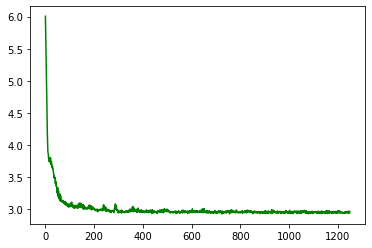

In [12]:
train_realnvp(realnvp, X_train)

Now evaluate your model: calculate NLL in bits on your validation set.

In [13]:
realnvp.eval()

# Implement NLL calculation on X_val data
total_loss = 0

dataset = torch.utils.data.TensorDataset(torch.Tensor(X_val).to(device))
val_dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=True)

with torch.no_grad():
    for x in val_dataloader:
        predictions, objective = realnvp(x[0])
        predictions = predictions.view(-1,1)
        uniform = Uniform(torch.tensor(0.0).to(device), torch.tensor(1.0).to(device))
        loss = - 1 * (torch.mean(torch.sum(uniform.log_prob(predictions), dim=1)) + torch.mean(objective))
        total_loss += loss * x[0].shape[0]
    avg_loss = total_loss / len(val_dataloader.dataset)

val_nll_bits = avg_loss.item()
print("NLL on validation set in bits: {}".format(val_nll_bits))

NLL on validation set in bits: 2.947920083999634


Feel free to tune your model parameters to improve your NLL score!

Now it's time for some visualizations! Let's calculate flow values of our validation data.

In [14]:
sampled_flow = realnvp(torch.Tensor(X_val).to(device))[0].detach().cpu().numpy()

Now we will visualize our points before and after passing throw the flow, leaving the label color.

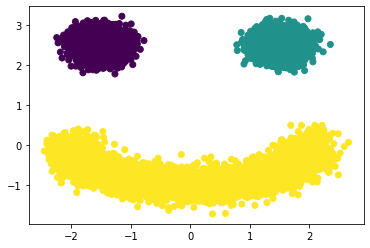

In [15]:
plt.scatter(X_val.T[0], X_val.T[1], c = Y_val)
plt.show()

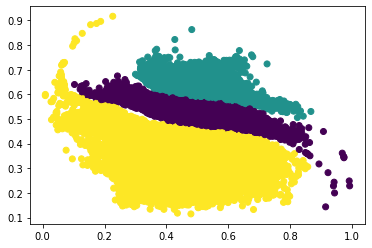

In [16]:
plt.scatter(sampled_flow.T[0], sampled_flow.T[1], c = Y_val)
plt.show()

Finally, let's perform sampling from RealNVP and visualize their histogram to compare with testing data.

In [17]:
def sample_from_realnvp(model):
    x1 = random.random()
    x2 = random.random()
    latent = torch.Tensor([[x1, x2]]).to(device)
    result = realnvp.reverse(latent)[0]
    
    return result.detach().cpu().numpy()

In [18]:
sampled_data = [sample_from_realnvp(realnvp) for _ in range(X_test.shape[0])]

In [19]:
sampled_data = np.array(sampled_data)

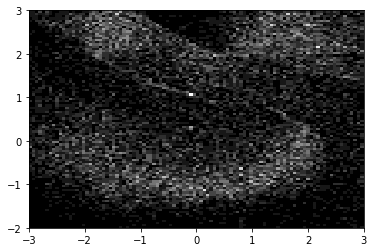

In [20]:
plt.hist2d(sampled_data.T[0], sampled_data.T[1], bins=100, cmap='gray',range=[[-3, 3], [-2, 3]])
plt.show()

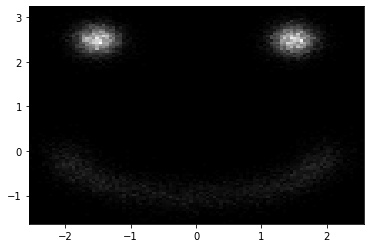

In [21]:
plt.hist2d(X_test.T[0], X_test.T[1], bins=100, cmap='gray')
plt.show()